# Vegagreining á gervitunglamyndum
Nathan HK

In [1]:
import gc
from io import BytesIO
import math
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import psutil
from pyrosm import OSM
from pyrosm import get_data
from selenium.common.exceptions import NoSuchElementException
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from shapely.geometry import Point
import sklearn as sk
from sklearn.model_selection import train_test_split
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
import tracemalloc


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.1.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/py

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.1.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/py

AttributeError: _ARRAY_API not found

In [2]:
mappa = '/Users/002-nathan/Desktop/Envalys/gtm/'
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

## Inngangsorð
Við viljum þjálfa gervigreindarlíkan til að greina vegi á gervitunglamyndum. Við þurfum tvenn gögn: gervitunglamyndir og staðsetningar vega.
- **Gervitunglamyndir:** Við notum skjámyndatökur af Já.is. Ég veit ekki hvort þetta sé löglegt, en ég er ekki með neinar betri leiðir.
- **Staðsetningar vega:** Við notum OpenStreetMap.

Ég nota Apple M1 Pro-örgjörvi með 16 GB minni.

## Gervitunglamyndir
Við notum lista yfir greinar á ensku Wikipediunni um staði á Höfuðborgarsvæðinu og Akureyri. Gögnin á Landsbyggðinni eru ekki nóg nákvæm fyrir þetta líkan.

In [3]:
byrjun = time.time()
hnitlisti = []
hnit_sv = {'h':[(64.167, 64.073, -21.649992, -22.041892, 30, 40),
                (64.073, 64.033177, -21.871, -22.041892, 20, 20),
                (64.200015, 64.167, -21.649992, -21.763, 10, 10)],
           'a':[(65.706074, 65.656070, -18.073935, -18.148693, 10, 10)]}
for svk in hnit_sv:
    for hnit_h in hnit_sv[svk]:
        diff = (hnit_h[0] - hnit_h[1], hnit_h[2] - hnit_h[3])
        for i in range(hnit_h[4]):
            lat = round(hnit_h[1] + (i * 2 + 1) * diff[0] / 60, 6)
            for j in range(hnit_h[5]):
                lon = round(hnit_h[3] + (j * 2 + 1) * diff[1] / 60, 6)
                hnitlisti.append((svk, lat, lon))
"""
for a in os.listdir(mappa):
    s = a.split('_')
    if len(s) != 3 or s[0] not in ['h', 'a', 'd'] or s[2][-4:] != '.png':
        continue
    tp = (s[0], float(s[1]), float(s[2][:-4]))
    if tp not in hnitlisti:
        hnitlisti.append(tp)
"""
print(len(hnitlisti))

1800


Við getum ekki tekið myndir af miðjunni skjásins, því það eru önnur HTML-efni sem hylja gervitunglamyndirnar. Þess vegna leitum við að staði sem eru 0.002° til austurs frá myndatökustaðnum; hérna eru hnitin á skjánum fyrir þennan stað.

In [4]:
skhn = (746, 861)

Við tökum skjámyndir af öllum stöðum á hnitlistanum.
- URL-ið notar ISN93-hnit, en okkar hnit eru WGS84, og það er engin einföld leið til að skipta milli þeirra. Þess vegna þurfum við að leita að hnitum eins og manneskja myndi leita.
- Á Chrome er myndasvæðið 512x512, en þegar myndin er vistuð verður hún 1024x1024.

In [5]:
byrjun = time.time()
f = False
for n in range(len(hnitlisti)):
    hnit = hnitlisti[n]
    try:
        z = open(mappa + hnit[0] + '_' + str(hnit[1]) + '_' + str(hnit[2]) + '.png', 'rb')
        z.close()
    except FileNotFoundError:
        f = True
        break
if f:
    driver = webdriver.Chrome()
    driver.set_window_size(1500, 1000)
    driver.get('https://ja.is/kort/?x=356954&y=408253&nz=17.00&type=aerialnl')
    # Accept GDPR
    try:
        btn = driver.find_element(By.XPATH, '//a[@id="gdpr_banner_ok"]')
        btn.click()
    except NoSuchElementException:
        pass
    # Allow cookies
    try:
        btn = driver.find_element(By.XPATH, '//button[@class="ch2-btn ch2-allow-all-btn ch2-btn-primary"]')
        btn.click()
    except NoSuchElementException:
        pass
    leit = driver.find_element(By.XPATH, '//input[@id="mapq"]')
    for n in range(len(hnitlisti)):
        if n % 100 == 0:
            print(n, time.time() - byrjun)
        hnit = hnitlisti[n]
        try:
            # Does file exist?
            z = open(mappa + hnit[0] + '_' + str(hnit[1]) + '_' + str(hnit[2]) + '.png', 'rb')
            z.close()
        except FileNotFoundError:
            # Input search term into search box
            leit.clear()
            leit.send_keys(str(hnit[1]) + ', ' + str(hnit[2] + 0.002))
            leit.send_keys(Keys.RETURN)
            time.sleep(2) # Wait for images to load
            try:  # Place not found
                nf = driver.find_element(By.XPATH, '//div[@class="row not-found"]')
            except NoSuchElementException:  # Place found, save and crop screenshot
                driver.save_screenshot(mappa + hnit[0] + '_' + str(hnit[1]) + '_' + str(hnit[2]) + '.png')
                skmynd = Image.open(mappa + hnit[0] + '_' + str(hnit[1]) + '_' + str(hnit[2]) + '.png')
                skmynd = skmynd.crop((skhn[0] - 512, skhn[1] - 512, skhn[0] + 512, skhn[1] + 512))
                skmynd.save(mappa + hnit[0] + '_' + str(hnit[1]) + '_' + str(hnit[2]) + '.png')
            time.sleep(1)
    driver.close()
print(time.time() - byrjun)

0.04396414756774902


## Staðsetningar vega
Við sækjum gögn frá OpenStreetMap.

In [6]:
fp = get_data('Iceland')

Þetta undirforrit tekur díl á myndinni og finnur GPS-hnitin. Við notum Web Mercator.

In [7]:
def pix2coord(pix, hnit_br):
    x_t = hnit_br[1] + (pix[0] - 512) / 1024
    lon = math.degrees(x_t * 2 * math.pi / (2 ** 17) - math.pi)
    y_t = hnit_br[0] + (pix[1] - 512) / 1024
    lat = math.degrees(2 * (math.atan(math.exp(math.pi - y_t * 2 * math.pi / (2 ** 17))) - math.pi / 4))
    return (lat, lon)

Þetta undirforrit tekur GPS-hnit og finnur dílinn á myndinni. Forritað með aðstoð frá o1-preview eftir OpenAI.

In [8]:
def coord2pix(lat, lon, hnit_br):
    # Convert degrees to radians
    lon_radians = math.radians(lon)
    lat_radians = math.radians(lat)
    
    # Invert the calculation for x_t
    x_t = ((lon_radians + math.pi) * (2 ** 17)) / (2 * math.pi)
    # Calculate pix[0] (x-coordinate)
    pix_x = (x_t - hnit_br[1]) * 1024 + 512
    
    # Invert the calculation for y_t
    b = lat_radians / 2 + math.pi / 4
    a = math.tan(b)
    c = math.pi - math.log(a)
    y_t = c * (2 ** 17) / (2 * math.pi)
    # Calculate pix[1] (y-coordinate)
    pix_y = (y_t - hnit_br[0]) * 1024 + 512
    
    return (pix_x, pix_y)

Við sækjum tvo lista: einn yfir vegi á Höfuðborgarsvæðinu, og einn á Akureyri.

In [9]:
byrjun = time.time()
veg_listi = {}
osm_h = OSM(fp, bounding_box=[-22.140901, 63.847886, -21.152576, 64.390306])
veg_listi['h'] = osm_h.get_network(network_type='driving')
osm_a = OSM(fp, bounding_box=[-18.398071, 65.543087, -17.968359, 66.576398])
veg_listi['a'] = osm_a.get_network(network_type='driving')
print(time.time() - byrjun)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pyrosm/networks.py:37: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  edges, nodes = prepare_geodataframe(


19.52343773841858


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pyrosm/networks.py:37: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  edges, nodes = prepare_geodataframe(


Við búum til lista yfir vegamót á hverri mynd.

In [10]:
byrjun = time.time()
X_gogn = []
y_gogn = []
bd_all = {}
for st in ['h', 'a']:
    vegir = veg_listi[st]
    bd = []
    for k in range(vegir.shape[0]):
        bns = vegir['geometry'][k].bounds
        bd.append(bns)
    bd_all[st] = bd
for n in range(len(hnitlisti)):
    if n % 100 == 0:
        print(n, time.time() - byrjun)
    hnit = hnitlisti[n]
    # Open image
    try:
        gtm = Image.open(mappa + hnit[0] + '_' + str(hnit[1]) + '_' + str(hnit[2]) + '.png')
        dilar = gtm.load()
    except FileNotFoundError:
        continue
    except OSError:
        print('OSError', hnit)
        continue
    # Convert coordinates
    y_n = 1 / (2 * math.pi) * 2 ** 17 * (math.pi - math.log(math.tan(math.pi / 4 + math.radians(hnit[1]) / 2))) - 0.5
    y_s = 1 / (2 * math.pi) * 2 ** 17 * (math.pi - math.log(math.tan(math.pi / 4 + math.radians(hnit[1]) / 2))) + 0.5
    if hnit[0] == 'd':
        vegir = veg_listi['h']
    else:
        vegir = veg_listi[hnit[0]]
    hnit_br = (1 / (2 * math.pi) * 2 ** 17 * (math.pi - math.log(math.tan(math.pi / 4 + math.radians(hnit[1]) / 2))),
               1 / (2 * math.pi) * 2 ** 17 * (math.pi + math.radians(hnit[2])))
    # Buildings
    y_mynd = np.zeros((1, 1, 1024, 1024))
    if hnit[0] == 'd':
        bd = bd_all['h']
    else:
        bd = bd_all[hnit[0]]
    hnitskra = {}
    for v in range(vegir.shape[0]):
        bns = bd[v]
        if bns[0] > hnit[2] + 0.0014 or bns[1] > hnit[1] + 0.0008 or bns[2] < hnit[2] - 0.0014 or bns[3] < hnit[1] - 0.0008:
            continue
        NW = coord2pix(bns[3], bns[0], hnit_br)
        SE = coord2pix(bns[1], bns[2], hnit_br)
        if NW[0] > 1024 or NW[1] > 1024 or SE[0] < 0 or SE[1] < 0:
            continue
        for p in vegir.loc[v, 'geometry'].geoms:
            x, y = p.xy
            try:
                hnitskra[(y[0], x[0])] += 1
            except KeyError:
                hnitskra[(y[0], x[0])] = 1
            try:
                hnitskra[(y[1], x[1])] += 1
            except KeyError:
                hnitskra[(y[1], x[1])] = 1
    mot = []
    for p in hnitskra:
        if hnitskra[p] > 2:
            ct = coord2pix(p[0], p[1], hnit_br)
            if ct[0] >= 0 and ct[0] < 1024 and ct[1] >= 0 and ct[1] < 1024:
                mot.append(ct)
    if hnit[0] != 'd' and len(mot) > 0:
        X_gogn.append(torch.tensor(np.transpose(np.array(gtm.getdata()).reshape(1024, 1024, 3), 
                                                (2, 0, 1)).reshape(1, 3, 1024, 1024), dtype=torch.float32).to(device))
        y_gogn.append(torch.tensor(np.array(mot).reshape(1, -1, 2), dtype=torch.float32).to(device))
    gtm.close()
print(time.time() - byrjun)

0 0.19600892066955566
100 8.102512836456299
200 14.593897819519043
300 24.580086946487427
400 32.83543086051941
500 41.49884796142578
600 48.73004484176636
700 58.24668788909912
800 66.7892427444458
900 77.31609272956848
1000 85.65528082847595
1100 91.50992774963379
1200 96.03811192512512
1300 103.24118185043335
1400 114.99784588813782
1500 124.77246689796448
1600 135.80263590812683
1700 139.68189191818237
143.54815292358398


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_gogn, y_gogn)

## Líkan 1
Hérna er CNN sem býr til tvær greypingar: eina fyrir myndina og eina fyrir hnitlistann. Markmið þessa líkans er að greypingar séu samar.

Forritað með aðstoð frá o1-preview.

In [12]:
no_points_embedding = nn.Parameter(torch.randn(128).to(device))

In [13]:
# Define a CNN for image processing (ResNet18 as an example)
class ImageEncoder(nn.Module):
    def __init__(self):
        super(ImageEncoder, self).__init__()
        # Using a pre-trained ResNet18 model
        self.resnet = models.resnet18(pretrained=True)
        # Modify the last layer to output a 128-dimensional feature vector
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, 128)

    def forward(self, images):
        return self.resnet(images)

In [14]:
# Define the LSTM-based embedding model for coordinates
class CoordinateEmbedding(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(CoordinateEmbedding, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, coordinates):
        lstm_out, _ = self.lstm(coordinates)
        embedding = self.fc(lstm_out[:, -1, :])  # Use last hidden state as embedding
        return embedding

In [15]:
# Combine both models into a final training model
class SatelliteModel(nn.Module):
    def __init__(self, image_encoder, coordinate_encoder, embedding_size=128):
        super(SatelliteModel, self).__init__()
        self.image_encoder = image_encoder
        self.coordinate_encoder = coordinate_encoder
        # Define a special embedding for "no points" (either zero or learnable)
        self.no_points_embedding = no_points_embedding

    def forward(self, images, coordinates=None):
        # Encode the image
        image_features = self.image_encoder(images)  # Shape: (batch_size, 128)
        
        if coordinates is not None and coordinates.shape[1] > 0:
            # If coordinates exist, get the coordinate embedding
            coordinate_embedding = self.coordinate_encoder(coordinates)
        else:
            # If no coordinates, use the "no points" embedding
            coordinate_embedding = self.no_points_embedding.expand(images.size(0), -1)

        return image_features, coordinate_embedding

In [16]:
epochs = 10

In [17]:
byrjun = time.time()
# Initialize both models
image_encoder = ImageEncoder()
coordinate_encoder = CoordinateEmbedding(input_size=2, hidden_size=128, output_size=128)

# Combine into final model
likan = SatelliteModel(image_encoder, coordinate_encoder).to(device)

# Define a loss function and optimizer
criterion = nn.MSELoss()  # Since we are predicting embeddings, we can use MSELoss
optimizer = optim.Adam(likan.parameters(), lr=1e-4)

train_loss = []
test_loss = []

for e in range(epochs):
    likan.eval()
    with torch.no_grad():
        rl = 0.0
        for i in range(len(X_train)):
            image_features, coordinate_embedding = likan(X_train[i], y_train[i])
            loss = criterion(image_features, coordinate_embedding)
            rl += loss.item()
        train_loss.append(rl / len(X_train))
        rl = 0.0
        for i in range(len(X_test)):
            image_features, coordinate_embedding = likan(X_test[i], y_test[i])
            loss = criterion(image_features, coordinate_embedding)
            rl += loss.item()
        test_loss.append(rl / len(X_test))
    torch.mps.empty_cache()
    
    likan.train()
    for i in range(len(X_train)):
    # Forward pass: get image features and coordinate embeddings
        image_features, coordinate_embedding = likan(X_train[i], y_train[i])
        
        # Loss: comparing image features with coordinate embeddings
        loss = criterion(image_features, coordinate_embedding)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()
        if i % 10 == 0:
            torch.mps.empty_cache()
        
    torch.mps.empty_cache()

    # Print loss for the current epoch
    print(f'Epoch [{e+1}/{epochs}], Time: {time.time() - byrjun}')

likan.eval()
with torch.no_grad():
    rl = 0.0
    for i in range(len(X_train)):
        image_features, coordinate_embedding = likan(X_train[i], y_train[i])
        loss = criterion(image_features, coordinate_embedding)
        rl += loss.item()
    train_loss.append(rl / len(X_train))
    rl = 0.0
    for i in range(len(X_test)):
        image_features, coordinate_embedding = likan(X_test[i], y_test[i])
        loss = criterion(image_features, coordinate_embedding)
        rl += loss.item()
    test_loss.append(rl / len(X_test))
torch.mps.empty_cache()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10], Time: 67.93509411811829
Epoch [2/10], Time: 134.53741693496704
Epoch [3/10], Time: 200.9545862674713
Epoch [4/10], Time: 267.75363421440125
Epoch [5/10], Time: 334.33025002479553
Epoch [6/10], Time: 401.11605405807495
Epoch [7/10], Time: 467.9062011241913
Epoch [8/10], Time: 534.4158551692963
Epoch [9/10], Time: 600.9403700828552
Epoch [10/10], Time: 667.8890202045441


### Mat

In [18]:
print('Train loss:', train_loss[-1])
print('Test loss:', test_loss[-1])

Train loss: 0.009821970458606574
Test loss: 0.009978695755298849


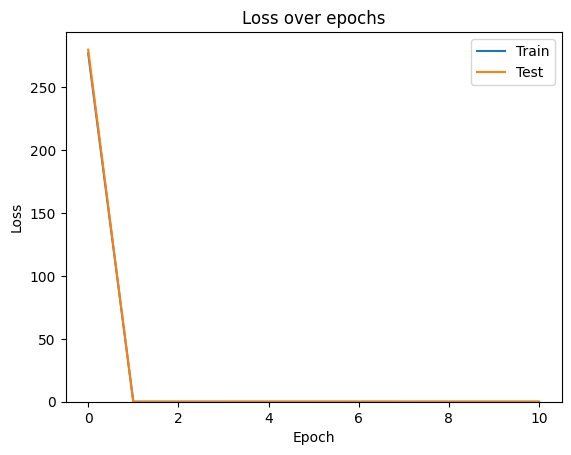

In [19]:
plt.plot(train_loss, label='Train')
plt.plot(test_loss, label='Test')
plt.ylim(bottom=0)
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

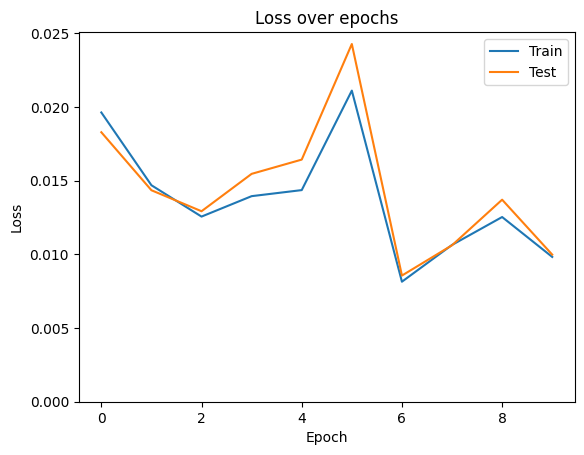

In [20]:
plt.plot(train_loss[1:], label='Train')
plt.plot(test_loss[1:], label='Test')
plt.ylim(bottom=0)
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Líkan 2
Þetta líkan tekur hnitlistagreypingu og reynir að útreikna hnitlistann.

In [21]:
def chamfer_distance(pred_points, target_points):
    """
    pred_points: List of tensors of shape (Ni, D), where Ni is the number of points in the i-th prediction.
    target_points: List of tensors of shape (Mi, D), where Mi is the number of points in the i-th target.
    """
    total_loss = 0.0
    batch_size = len(pred_points)
    for pred, target in zip(pred_points, target_points):
        if pred.numel() == 0 and target.numel() == 0:
            # Both sequences are empty; loss is zero.
            loss = 0.0
        elif pred.numel() == 0 or target.numel() == 0:
            # One sequence is empty; define loss appropriately (e.g., sum of squared norms).
            non_empty = pred if pred.numel() != 0 else target
            loss = non_empty.pow(2).sum()
        else:
            # Compute pairwise distances.
            diff = pred.unsqueeze(1) - target.unsqueeze(0)  # Shape: (Ni, Mi, D)
            dist = torch.norm(diff, dim=2)  # Shape: (Ni, Mi)
            # For each point in pred, find the closest point in target.
            min_pred_to_target = dist.min(dim=1)[0]
            # For each point in target, find the closest point in pred.
            min_target_to_pred = dist.min(dim=0)[0]
            # Sum the minimal distances.
            loss = min_pred_to_target.sum() + min_target_to_pred.sum()
        total_loss += loss
    return total_loss / batch_size

In [22]:
class CoordinateDecoder(nn.Module):
    def __init__(self, embedding_size, hidden_size, output_size=2, num_layers=1):
        super(CoordinateDecoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # The initial hidden state is derived from the embedding
        self.fc_embed = nn.Linear(embedding_size, hidden_size * num_layers)

        # LSTM decoder
        self.lstm = nn.LSTM(input_size=output_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc_out = nn.Linear(hidden_size, output_size)
        self.fc_stop = nn.Linear(hidden_size, 1)  # Predicts probability to stop

    def forward(self, embedding, max_seq_length):
        batch_size = embedding.size(0)

        # Initialize hidden state from embedding
        h_0 = self.fc_embed(embedding)
        h_0 = h_0.view(self.num_layers, batch_size, self.hidden_size)
        c_0 = torch.zeros_like(h_0)  # You can also learn c_0 or set it differently

        # Prepare the initial input (e.g., start token or zeros)
        decoder_input = torch.zeros(batch_size, 1, 2).to(embedding.device)  # Starting with zero coordinates

        outputs = []
        stop_probs = []
        for t in range(max_seq_length):
            # LSTM step
            output, (h_0, c_0) = self.lstm(decoder_input, (h_0, c_0))
            coord_pred = self.fc_out(output)
            stop_logit = self.fc_stop(output)
            stop_prob = torch.sigmoid(stop_logit)

            outputs.append(coord_pred)
            stop_probs.append(stop_prob)

            # Check if all sequences have predicted stop
            if torch.all(stop_prob > 0.5):
                break

            decoder_input = coord_pred  # Or use teacher forcing
            
        if len(outputs) == 0:
            outputs = torch.tensor(np.zeros((1, 0, 2)), dtype=torch.float32).to(device)
            stop_probs = torch.tensor(np.zeros((0, 1)), dtype=torch.float32).to(device)
            return outputs, stop_probs

        outputs = torch.cat(outputs, dim=1)
        stop_probs = torch.cat(stop_probs, dim=1)
        return outputs, stop_probs

In [23]:
max_seq_length = max([z.shape[1] for z in y_train])
epochs = 200

In [24]:
for i in range(len(X_gogn)):
    X_gogn[i] = None
del X_gogn
for i in range(len(X_train)):
    X_train[i] = None
del X_train
for i in range(len(X_test)):
    X_test[i] = None
del X_test
gc.collect()
torch.mps.empty_cache()

In [25]:
byrjun = time.time()
# Initialize the decoder
coordinate_decoder = CoordinateDecoder(embedding_size=128, hidden_size=128).to(device)

# Define optimizer
decoder_optimizer = optim.Adam(coordinate_decoder.parameters(), lr=1e-4)

train_loss = []
test_loss = []

# DEBUG
minni_a = []
minni_u = []
minni_m = []
# END DEBUG

# Training loop for the decoder
likan.eval()
for e in range(epochs):
    coordinate_decoder.eval()
    with torch.no_grad():
        rl = 0.0
        for i in range(len(y_train)):
            coord_embeddings = likan.coordinate_encoder(y_train[i])
            seq_length = y_train[i].size(1)
            output_sequences, stop_probs = coordinate_decoder(coord_embeddings, seq_length)
            loss = chamfer_distance(output_sequences, y_train[i])
            rl += loss.item()
        train_loss.append(rl / len(y_train))
        rl = 0.0
        for i in range(len(y_test)):
            coord_embeddings = likan.coordinate_encoder(y_test[i])
            seq_length = y_train[i].size(1)
            output_sequences, stop_probs = coordinate_decoder(coord_embeddings, seq_length)
            loss = chamfer_distance(output_sequences, y_test[i])
            rl += loss.item()
        test_loss.append(rl / len(y_test))

    torch.mps.empty_cache()
        
    coordinate_decoder.train()
    for i in range(len(y_train)):
        # Get image embeddings
        with torch.no_grad():
            coord_embeddings = likan.coordinate_encoder(y_train[i])

        # Forward pass thru decoder
        seq_length = y_train[i].size(1)
        output_sequences, stop_probs = coordinate_decoder(coord_embeddings, seq_length)

        # Compute loss
        loss = chamfer_distance(output_sequences, y_train[i])

        # Backpropagation and optimization
        decoder_optimizer.zero_grad()
        loss.backward(retain_graph=True)
        decoder_optimizer.step()
        if i % 10 == 0:
            torch.mps.empty_cache()

    gc.collect()
    torch.mps.empty_cache()

    minni_m.append(torch.mps.current_allocated_memory())  # DEBUG
    minni_a.append(psutil.virtual_memory().available)  # DEBUG
    minni_u.append(psutil.virtual_memory().used)  # DEBUG

    print(f'Epoch [{e+1}/{epochs}], Time: {time.time() - byrjun}')

coordinate_decoder.eval()
with torch.no_grad():
    rl = 0.0
    for i in range(len(y_train)):
        coord_embeddings = likan.coordinate_encoder(y_train[i])
        seq_length = y_train[i].size(1)
        output_sequences, stop_probs = coordinate_decoder(coord_embeddings, seq_length)
        loss = chamfer_distance(output_sequences, y_train[i])
        rl += loss.item()
    train_loss.append(rl / len(y_train))
    rl = 0.0
    for i in range(len(y_test)):
        coord_embeddings = likan.coordinate_encoder(y_test[i])
        seq_length = y_train[i].size(1)
        output_sequences, stop_probs = coordinate_decoder(coord_embeddings, seq_length)
        loss = chamfer_distance(output_sequences, y_test[i])
        rl += loss.item()
    test_loss.append(rl / len(y_test))
    torch.mps.empty_cache()

Epoch [1/200], Time: 7.082580089569092
Epoch [2/200], Time: 10.83011794090271
Epoch [3/200], Time: 13.577229976654053
Epoch [4/200], Time: 16.335322856903076
Epoch [5/200], Time: 19.06389307975769
Epoch [6/200], Time: 21.865118980407715
Epoch [7/200], Time: 24.56045389175415
Epoch [8/200], Time: 27.29058003425598
Epoch [9/200], Time: 30.189048051834106
Epoch [10/200], Time: 32.88700294494629
Epoch [11/200], Time: 35.60251593589783
Epoch [12/200], Time: 38.33243799209595
Epoch [13/200], Time: 40.982836961746216
Epoch [14/200], Time: 43.67223906517029
Epoch [15/200], Time: 46.424554109573364
Epoch [16/200], Time: 49.127395153045654
Epoch [17/200], Time: 51.86278820037842
Epoch [18/200], Time: 54.55470418930054
Epoch [19/200], Time: 57.271153926849365
Epoch [20/200], Time: 60.11692214012146
Epoch [21/200], Time: 62.87398719787598
Epoch [22/200], Time: 65.56611108779907
Epoch [23/200], Time: 68.45398497581482
Epoch [24/200], Time: 71.2607889175415
Epoch [25/200], Time: 73.92360091209412
Ep

In [26]:
print(minni_a[-1], minni_u[-1], minni_m[-1])

3786637312 6003933184 247608064


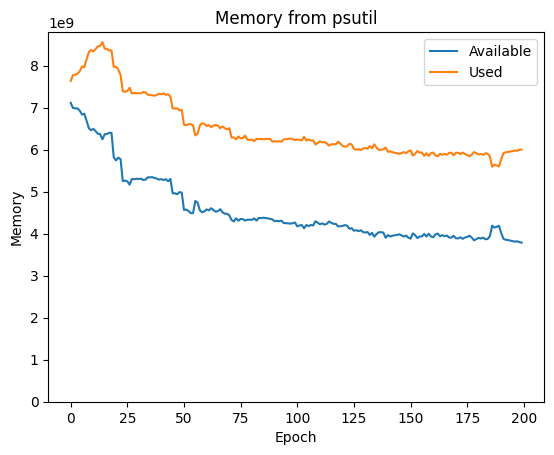

In [27]:
plt.plot(minni_a, label='Available')
plt.plot(minni_u, label='Used')
plt.title('Memory from psutil')
plt.xlabel('Epoch')
plt.ylabel('Memory')
plt.ylim(bottom=0)
plt.legend()
plt.show()

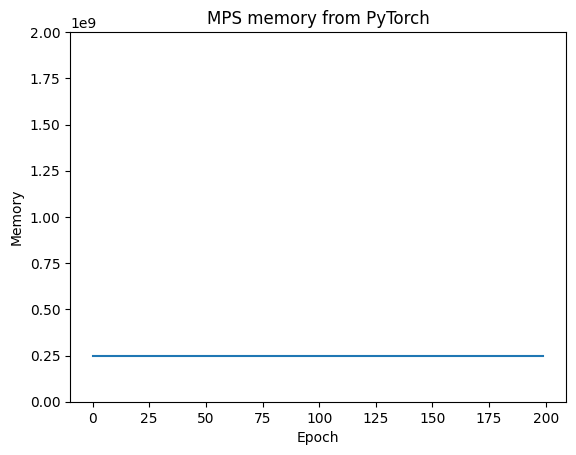

In [28]:
plt.plot(minni_m)
plt.title('MPS memory from PyTorch')
plt.xlabel('Epoch')
plt.ylabel('Memory')
plt.ylim(bottom=0, top=2e9)
plt.show()

### Mat

In [29]:
print('Train loss:', train_loss[-1])
print('Test loss:', test_loss[-1])

Train loss: 2062.0164040093405
Test loss: 2076.9360242786975


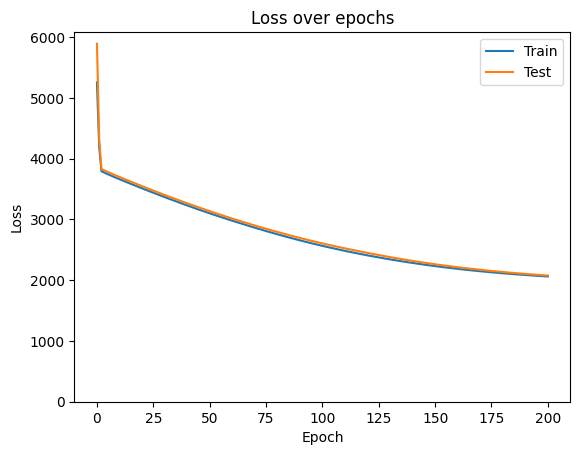

In [30]:
plt.plot(train_loss, label='Train')
plt.plot(test_loss, label='Test')
plt.ylim(bottom=0)
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Sýning

In [31]:
likan.eval()
coordinate_decoder.eval()
profmynd = Image.open(mappa + 'd_64.150678_-21.946834.png')
X_mynd = torch.tensor(np.transpose(np.array(profmynd.getdata()).reshape(1024, 1024, 3), 
                                   (2, 0, 1)).reshape(1, 3, 1024, 1024), dtype=torch.float32).to(device)

with torch.no_grad():
    # Get image embeddings
    image_embeddings = likan.image_encoder(X_mynd)

    # Decide on the maximum sequence length you want to generate
    max_seq_length = 20  # Adjust as needed

    # Generate coordinate sequences
    generated_sequences, prob = coordinate_decoder(image_embeddings, max_seq_length)

    # Now 'generated_sequences' contains the predicted coordinates

In [32]:
generated_sequences

tensor([[[360.4517, 371.5243]]], device='mps:0')

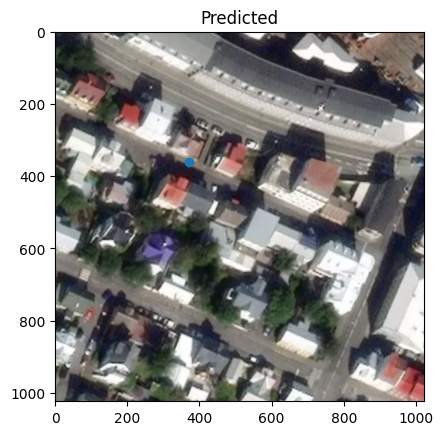

In [35]:
# Assuming 'generated_sequences' is of shape (batch_size, seq_length, 2)
coordinates = generated_sequences[0].cpu().numpy()  # Get coordinates for the first image

# Plot the coordinates
plt.imshow(profmynd)
plt.title('Predicted')
plt.scatter(coordinates[:, 1], coordinates[:, 0], marker='o')
plt.show()

## Lokaorð
Greiningin er enn í vinnslu.